In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.odr as odr
import numpy as np
import string
from sklearn.linear_model import LinearRegression

In [2]:
from matplotlib import rcParams

font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [3]:
df_prisma_phase0 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase0/PRISMA_data/emiss_summary.csv')
df_enmap_phase0 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase0/EnMAP_data/emiss_summary.csv')

df_prisma_phase1 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase1/PRISMA_data/emiss_summary.csv')
df_enmap_phase1 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase1/EnMAP_data/emiss_summary.csv')

df_prisma_phase2 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase2/PRISMA_data/emiss_summary.csv')
df_enmap_phase2 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase2/EnMAP_data/emiss_summary.csv')
df_emit_phase2 = pd.read_csv('/deos/xinz/stanford_controlled_release_2024/phase2/EMIT_data/emiss_summary.csv')

df_phase0 = pd.concat([df_prisma_phase0, df_enmap_phase0])

# check more data if you have them .....
# df_prisma_all = pd.concat([df_prisma_phase0, df_prisma_phase1, df_prisma_phase2])
# df_enmap_all = pd.concat([df_enmap_phase0, df_enmap_phase1, df_enmap_phase2])
# df_emit_all = pd.concat([df_emit_phase2])

# df_all = pd.concat([df_prisma_all, df_enmap_all, df_emit_all])

# df_prisma_all = pd.concat([df_prisma_phase0, df_prisma_phase1])
# df_enmap_all = pd.concat([df_enmap_phase0, df_enmap_phase1])

# df_all = pd.concat([df_prisma_all, df_enmap_all])

(0.0, 1200.0)

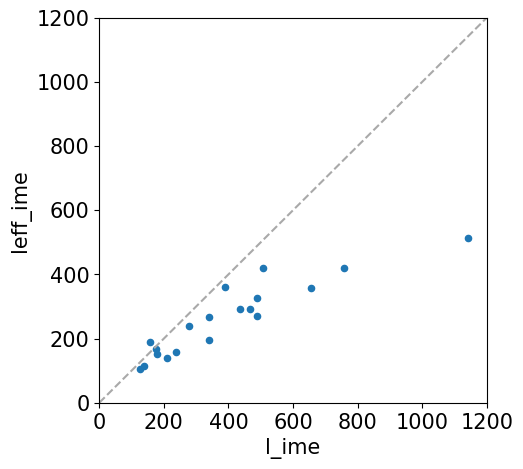

In [4]:
fig, axs = plt.subplots(figsize=(5, 5))

df_phase0[df_phase0['plume_limit'] == 0].plot.scatter(ax=axs, x='l_ime', y='leff_ime')

axs.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='darkgray', ls='--')

axs.set_xlim(0, 1200)
axs.set_ylim(0, 1200)

In [5]:
def fit_line_odr(x, y, sx=None, sy=None):
    # Define the linear function
    def linear_function(B, x):
        return B[0] * x #+ B[1]

    # Create a model
    linear_model = odr.Model(linear_function)

    # Create a RealData object with errors
    data = odr.RealData(x, y, sx=sx, sy=sy)

    # Set up ODR with the model and data
    # guess the initial via OLS
    # Reshape the arrays to 2D
    x_2d = x.reshape(-1, 1)
    y_2d = y.reshape(-1, 1)

    # Create and fit the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(x_2d, y_2d)

    # Get the slope of the linear regression line
    odr_instance = odr.ODR(data, linear_model, beta0=[model.coef_[0][0]])

    # Run the regression
    output = odr_instance.run()

    # Extract the parameter
    slope = output.beta[0]
    slope_err = output.sd_beta[0]
    # print('ODR slope err: ', slope_err)

    # Calculate R-squared (for model without intercept)
    y_pred = slope * x
    
    # Since there's no intercept, we use a modified R-squared calculation
    # For no-intercept models, R² = 1 - (sum of squared residuals / sum of squared y values)
    ss_residual = np.sum((y - y_pred) ** 2)
    ss_total = np.sum(y ** 2)  # Without centering around mean for no-intercept models
    r_squared = 1 - (ss_residual / ss_total)
    
    return slope, r_squared

In [6]:
def fit_line_odr(x, y, sx=None, sy=None):
    """
    Fit a line through the origin using Orthogonal Distance Regression (ODR).
    
    Parameters:
    -----------
    x : array-like
        Independent variable data
    y : array-like  
        Dependent variable data
    sx : array-like, optional
        Standard deviations/errors in x
    sy : array-like, optional
        Standard deviations/errors in y
        
    Returns:
    --------
    slope : float
        Fitted slope parameter
    r_squared : float
        Coefficient of determination
    slope_err : float
        Standard error of the slope
    """
    
    # Convert inputs to numpy arrays
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    
    # Validate input dimensions
    if x.shape != y.shape:
        raise ValueError(f"x and y must have the same shape. Got x: {x.shape}, y: {y.shape}")
    
    if len(x) < 2:
        raise ValueError("Need at least 2 data points for fitting")
    
    # Handle error arrays
    if sx is not None:
        sx = np.asarray(sx, dtype=float)
        if sx.shape != x.shape:
            raise ValueError(f"sx must have the same shape as x. Got sx: {sx.shape}, x: {x.shape}")
    
    if sy is not None:
        sy = np.asarray(sy, dtype=float)
        if sy.shape != y.shape:
            raise ValueError(f"sy must have the same shape as y. Got sy: {sy.shape}, y: {y.shape}")
    
    # Define the linear function (line through origin)
    def linear_function(B, x):
        return B[0] * x
    
    # Create ODR model
    linear_model = odr.Model(linear_function)
    
    # Create RealData object with errors
    data = odr.RealData(x, y, sx=sx, sy=sy)
    
    # Get initial guess using OLS (simpler approach)
    # For line through origin: slope = sum(xy) / sum(x²)
    if np.sum(x**2) == 0:
        raise ValueError("Cannot fit line: all x values are zero")
    
    initial_slope = np.sum(x * y) / np.sum(x**2)
    
    # Alternative using sklearn (your original approach, fixed)
    # x_2d = x.reshape(-1, 1)
    # y_2d = y.reshape(-1, 1)  
    # model = LinearRegression(fit_intercept=False)
    # model.fit(x_2d, y_2d)
    # initial_slope = model.coef_[0]  # Remove [0] indexing - coef_ is 1D for single output
    
    # Set up and run ODR
    odr_instance = odr.ODR(data, linear_model, beta0=[initial_slope])
    
    try:
        output = odr_instance.run()
    except Exception as e:
        raise RuntimeError(f"ODR fitting failed: {str(e)}")
    
    # Extract results
    slope = output.beta[0]
    slope_err = output.sd_beta[0]
    
    # Calculate R-squared for no-intercept model
    y_pred = slope * x
    ss_residual = np.sum((y - y_pred)**2)
    ss_total = np.sum(y**2)  # Total sum of squares for no-intercept model
    
    # Handle edge case where all y values are zero
    if ss_total == 0:
        r_squared = 1.0 if ss_residual == 0 else 0.0
    else:
        r_squared = 1 - (ss_residual / ss_total)
    
    return slope, r_squared, slope_err

In [7]:
def plot_fit(df, ax, limit=0,
             color='C0',
             fit_method='OLS',
             plot_scatter=False,
             scatter_alpha=1,
             limit_text=True,
             est_name='emission_domain',
             est_error_name='emission_uncertainty_domain',
             release_name='emission_release_5min',
             release_error_name='emission_uncertainty_release_5min',
            ):
    # subset the dataset by plume limit
    df = df[df['plume_limit'] == limit]

    df = df.dropna(subset=release_name)

    if fit_method == 'ODR':
        slope, r_squared, slope_err = fit_line_odr(df[release_name].values,
                                        df[est_name].values,
                                        sx=df[release_error_name].values,
                                        sy=df[est_error_name].values,
                                       )
    elif fit_method == 'OLS':
        import statsmodels.api as sm
        X = df[release_name].values[:, None]            # 2D design matrix, no constant
        model = sm.OLS(df[est_name].values, X).fit()
        slope = model.params[0]   # single coefficient
        slope_err = model.bse[0]  # standard error of the slope
        r_squared    = model.rsquared
    else:
        raise ValueError(f'{fit_method} is not supported')

    if limit == 0:
        if limit_text:
            label = f'No limit, y=({np.round(slope, 2)} ± {np.round(slope_err, 2)})x, R$^2$={np.round(r_squared, 2)}'
        else:
            label = f'y=({np.round(slope, 2)} ± {np.round(slope_err, 2)})x, R$^2$={np.round(r_squared, 2)}'
    else:
        if limit_text:
            label = f'{limit} m limit, y=({np.round(slope, 2)} ± {np.round(slope_err, 2)})x, R$^2$={np.round(r_squared, 2)}'
        else:
            label = f'y=({np.round(slope, 2)} ± {np.round(slope_err, 2)})x, R$^2$={np.round(r_squared, 2)}'

    ax.plot(np.arange(2e3), slope*np.arange(2e3),
        c=color, label=label,
       )
    
    if plot_scatter:
        ax.scatter(df[release_name],
                    df[est_name],
                    c=color,
                    # fmt='o', capsize=3,
                    s=12,
                    alpha=scatter_alpha,
                   )
    else:
        ax.errorbar(df[release_name],
                    df[est_name],
                    xerr=df[release_error_name],
                    yerr=df[est_error_name],
                    c=color,
                    fmt='o', capsize=3,
                    markersize=4, elinewidth=0.6,
                    # label=label,
                    # alpha=scatter_alpha,
                   )

In [8]:
def subplot_line(df, ax, fit_method='ODR'):
    plot_fit(df, ax=ax, limit=0, color='C0', fit_method=fit_method)
    plot_fit(df, ax=ax, limit=2500, color='darkorange', plot_scatter=True, fit_method=fit_method)
    plot_fit(df, ax=ax, limit=1000, color='red', plot_scatter=True, fit_method=fit_method)
    
    ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='darkgray', ls='--')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

def subplot_oneline(df, ax, fit_method='ODR'):
    plot_fit(df, ax=ax, limit=0, color='C0', fit_method=fit_method, limit_text=False)
    
    ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='darkgray', ls='--')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

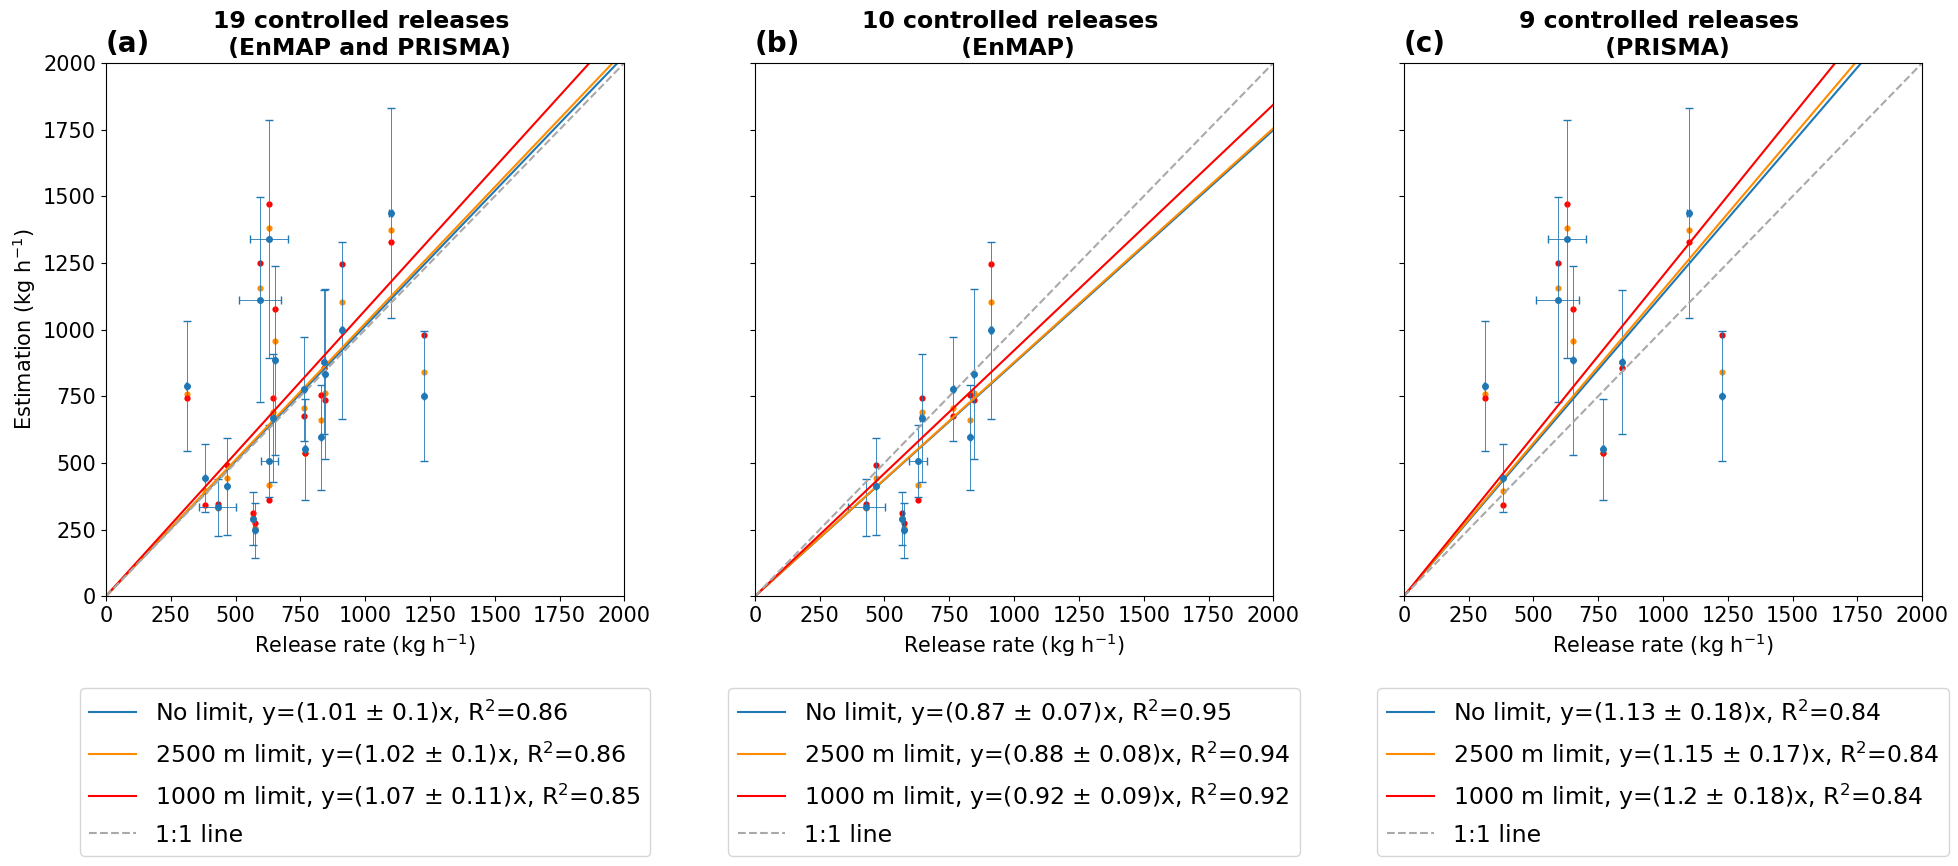

In [9]:
fig, axs = plt.subplots(figsize=(20, 9), ncols=3, sharex=True, sharey=True)

# subplot_oneline(df_phase0, axs[0], fit_method='OLS')
subplot_line(df_phase0, axs[0], fit_method='OLS')
axs[0].set_title(str(len(df_phase0.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP and PRISMA)')

subplot_line(df_enmap_phase0, axs[1], fit_method='OLS')
axs[1].set_title(str(len(df_enmap_phase0.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP)')

subplot_line(df_prisma_phase0, axs[2], fit_method='OLS')
axs[2].set_title(str(len(df_prisma_phase0.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (PRISMA)')

axs[0].set_ylabel('Estimation (kg h$^{-1}$)')
for ax in axs:
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('Release rate (kg h$^{-1}$)')

for n, ax in enumerate(axs):#[ax1, ax2, ax3, ax4]):
    ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
# fig.savefig('../figures/phase0_OLS.png')
fig.savefig('../figures/controlled_release.pdf')

In [10]:
# fig, axs = plt.subplots(figsize=(18, 8), ncols=3, sharex=True, sharey=True)

# subplot_line(df_phase0, axs[0], fit_method='ODR')
# axs[0].set_title(str(len(df_phase0.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP and PRISMA)')

# subplot_line(df_enmap_phase0, axs[1], fit_method='ODR')
# axs[1].set_title(str(len(df_enmap_phase0.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP)')

# subplot_line(df_prisma_phase0, axs[2], fit_method='ODR')
# axs[2].set_title(str(len(df_prisma_phase0.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (PRISMA)')

# axs[0].set_ylabel('Estimation (kg h$^{-1}$)')
# for ax in axs:
#     ax.set_xlim(0, 2000)
#     ax.set_ylim(0, 2000)
#     ax.set_xlabel('Release rate (kg h$^{-1}$)')

# fig.tight_layout()
# fig.savefig('../figures/phase0_ODR.png')

In [11]:
# fig, axs = plt.subplots(figsize=(8, 8))
# # df_all.plot.scatter(x='emission_domain', y='emission_release_5min', ax=axs)
# # df_all.plot.scatter(x='emission_domain', y='emission_release', ax=axs, c='darkorange')
# axs.scatter(df_all['emission_domain'], df_all['emission_release_5min'] - df_all['emission_domain'], c='C0')
# axs.scatter(df_all['emission_domain'], df_all['emission_release'] - df_all['emission_domain'], c='darkorange')
# axs.set_xlim(0, 2e3)
# axs.set_ylim(-1e3, 800)

In [12]:
# fig, axs = plt.subplots(figsize=(18, 7), ncols=3, sharex=True, sharey=True)
# axs = axs.flatten()

# subplot_oneline(df_all[df_all['plume_limit'] == 0], axs[0], fit_method='OLS')
# axs[0].set_title(str(len(df_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP and PRISMA)')

# subplot_oneline(df_enmap_all[df_enmap_all['plume_limit'] == 0], axs[1], fit_method='OLS')
# axs[1].set_title(str(len(df_enmap_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP)')

# subplot_oneline(df_prisma_all[df_prisma_all['plume_limit'] == 0], axs[2], fit_method='OLS')
# axs[2].set_title(str(len(df_prisma_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (PRISMA)')

# axs[0].set_ylabel('Estimation (kg h$^{-1}$)')
# axs[2].set_ylabel('Estimation (kg h$^{-1}$)')

# for ax in axs:
#     ax.set_xlim(0, 2000)
#     ax.set_ylim(0, 2000)
#     ax.tick_params(labelleft=True, labelbottom=True)
#     ax.set_ylabel('Estimation (kg h$^{-1}$)')
#     ax.set_xlabel('Release rate (kg h$^{-1}$)')

# fig.tight_layout()
# fig.savefig('../figures/phase0_phase1_OLS.png')

In [13]:
# fig, axs = plt.subplots(figsize=(12, 13), nrows=2, ncols=2, sharex=True, sharey=True)
# axs =axs.flatten()

# subplot_oneline(df_all, axs[0], fit_method='OLS')
# axs[0].set_title(str(len(df_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP, PRISMA, and EMIT)')

# subplot_oneline(df_enmap_all, axs[1], fit_method='OLS')
# axs[1].set_title(str(len(df_enmap_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP)')

# subplot_oneline(df_prisma_all, axs[2], fit_method='OLS')
# axs[2].set_title(str(len(df_prisma_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (PRISMA)')

# subplot_oneline(df_emit_all, axs[3], fit_method='OLS')
# axs[3].set_title(str(len(df_emit_all.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EMIT)')

# axs[0].set_ylabel('Estimation (kg h$^{-1}$)')
# axs[2].set_ylabel('Estimation (kg h$^{-1}$)')

# for ax in axs:
#     ax.set_xlim(0, 2000)
#     ax.set_ylim(0, 2000)
#     ax.tick_params(labelleft=True, labelbottom=True)
#     ax.set_ylabel('Estimation (kg h$^{-1}$)')
#     ax.set_xlabel('Release rate (kg h$^{-1}$)')

# fig.tight_layout()
# # fig.savefig('../figures/phase0_phase1_phase2_OLS.png')

In [14]:
# fig, axs = plt.subplots(figsize=(18, 8), ncols=3, sharex=True, sharey=True)

# subplot_line(df_both, axs[0], fit_method='ODR')
# axs[0].set_title(str(len(df_both.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP and PRISMA)')

# subplot_line(df_enmap_both, axs[1], fit_method='ODR')
# axs[1].set_title(str(len(df_enmap_both.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (EnMAP)')

# subplot_line(df_prisma_both, axs[2], fit_method='ODR')
# axs[2].set_title(str(len(df_prisma_both.drop_duplicates(subset=['plume_id'])))+' controlled releases \n (PRISMA)')

# axs[0].set_ylabel('Estimation (kg h$^{-1}$)')
# for ax in axs:
#     ax.set_xlim(0, 2000)
#     ax.set_ylim(0, 2000)
#     ax.set_xlabel('Release rate (kg h$^{-1}$)')

# fig.tight_layout()
# fig.savefig('../figures/phase0_phase1_ODR.png')

In [15]:
# import plotly.express as px
# import plotly.graph_objects as go

# df_plot = df_enmap_all

# fig = px.scatter(df_plot[df_plot['plume_limit'] == 0],
#                  x="emission_release_5min",
#                  y='emission_domain',
#                  color="wind_speed_reanalysis",
#                  # size='petal_length',
#                  error_x="emission_uncertainty_release_5min",
#                  error_y="emission_uncertainty_domain",
#                  hover_data=['plume_id', 'datetime',
#                  #             'emission_release', yname, ueff_name,
#                  #             'wind_speed_obs', 'wind_speed_reanalysis',
#                  #             'tau_min', 'tau_obs',
#                             ],
#                  trendline="ols",
#                  trendline_options={"add_constant": False},
#                  # color_continuous_scale='viridis',
#                 )
# fig.add_trace(go.Scatter(x=[0, 2e3], y=[0, 2e3], mode='lines', 
#                      line=dict(color='grey', dash='dash'),
#                          name='1:1 Line')
#              )

# fig.update_layout(width=700, height=600, yaxis_range=[0, 2e3], xaxis_range=[0, 2e3])
# fig.show()